In [2]:
import os
import cv2
import json
import numpy as np

In [3]:
def get_dataset_paths(data_path):
    '''
    Get the file paths for the real and synthetic data
    :param data_path: The path to the data
    :return: real_data_files: The file paths for the real data
             synthetic_data_files: The file paths for the synthetic data
    '''
    # Load all the image file paths for real and synthetic data
    synthetic_data = os.path.join(data_path, "ThisPersonDoesNotExist")
    synthetic_data_files = []
    for dir in os.listdir(synthetic_data):
        synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

    # Load the json subset of the real data
    with open("real_faces_subset.json") as f:
        real_data_json = json.load(f)
    
    # Build the real data file paths
    real_data_files = []
    for file_entry in real_data_json['files']:
        file_name = file_entry.split("/")[-1]
        file_path = os.path.join(data_path, "images1024x1024", file_name)
        real_data_files.append(file_path)
    
    return real_data_files, synthetic_data_files


def load_and_resize_images(file_paths, size=(64, 64)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        images.append(image)
    return np.array(images)


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])


def augment_data(X_images, augmentations, n_augmentations=5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def jitter_image(image):
    '''
    Randomly shifts the image either up, down, left or right by a random small amount of pixels
    :param image: The image to jitter
    :return: The jittered image
    '''
    # Choose a random direction to shift the image
    direction = np.random.choice(["up", "down", "left", "right"])
    # Choose a random amount to shift the image
    amount = np.random.randint(1, 10)
    # Sample a random pixel on the direction edge for the color to use
    # This does not look as good as it sounds
    if direction == "up":
        color = image[0, np.random.randint(0, image.shape[1])]
    elif direction == "down":
        color = image[-1, np.random.randint(0, image.shape[1])]
    elif direction == "left":
        color = image[np.random.randint(0, image.shape[0]), 0]
    else:
        color = image[np.random.randint(0, image.shape[0]), -1]

    # Shift the image and replace the empty space with border color pixels
    if direction == "up":
        jittered_image = np.vstack((np.full((amount, image.shape[1], 3), color), image[:-amount]))
    elif direction == "down":
        jittered_image = np.vstack((image[amount:], np.full((amount, image.shape[1], 3), color)))
    elif direction == "left":
        jittered_image = np.hstack((np.full((image.shape[0], amount, 3), color), image[:, :-amount]))
    else:
        jittered_image = np.hstack((image[:, amount:], np.full((image.shape[0], amount, 3), color)))
    return jittered_image

In [4]:
real_files, synthetic_files = get_dataset_paths("dataset")
real_images = load_and_resize_images(real_files)
synthetic_images = load_and_resize_images(synthetic_files)

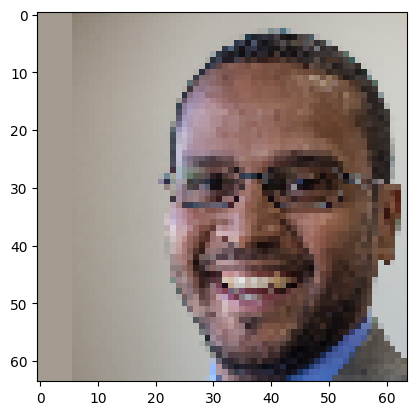

In [5]:
from matplotlib import pyplot as plt
img = real_images[0]
augmentations = [   lambda image: cv2.flip(image, 1),
                    lambda image: add_random_noise(image),
                    lambda image: jitter_image(image)]
img = augmentations[2](img)
plt.imshow(img)
# Not using jitter for now
augmentations = [lambda image: cv2.flip(image, 1),
                 lambda image: add_random_noise(image)]

In [6]:
target_dataset_size = 10000
real_images = augment_data(real_images, augmentations, target_dataset_size - len(real_images))
synthetic_images = augment_data(synthetic_images, augmentations, target_dataset_size - len(synthetic_images))
print(len(real_images))
print(len(synthetic_images))

10000
10000


In [7]:
# Combined Data with associated labels
X = np.concatenate((real_images, synthetic_images))
y_real = np.zeros(shape=(len(real_images), 2))
y_real[:, 0] = 1
y_synthetic = np.zeros(shape=(len(synthetic_images), 2))
y_synthetic[:, 1] = 1
y = np.concatenate((y_real, y_synthetic))

In [8]:
X, y = shuffle_data(X, y)

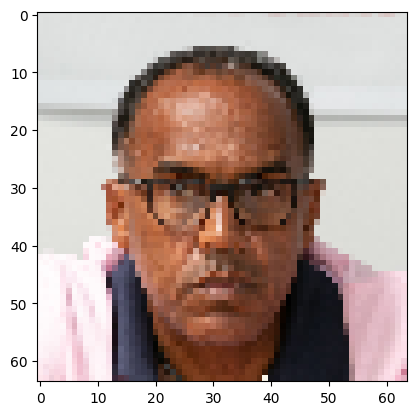

In [9]:
img = X[0]
plt.imshow(img)

In [10]:
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)

In [75]:
import torch
import torch.nn as nn
torch.manual_seed(0)

In [76]:
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
x_train_tensor = x_train_tensor.permute(0, 3, 1, 2)
x_val_tensor = x_val_tensor.permute(0, 3, 1, 2)
x_test_tensor = x_test_tensor.permute(0, 3, 1, 2)
x_train_tensor = x_train_tensor / 255
x_val_tensor = x_val_tensor / 255
x_test_tensor = x_test_tensor / 255
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_val_tensor = x_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [77]:
# Add Classifier to the Autoencoder
class ConvAutoencoderWithClassifier(nn.Module):
    def __init__(self, num_classes, latent_dim):
        super(ConvAutoencoderWithClassifier, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # [batch, 16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, 8, 8]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer to prevent overfitting
            nn.Linear(128, num_classes)
        )

    # Forward pass
    def forward(self, x):
        x = self.encoder(x)
        reconstructed = self.decoder(x)
        classification_logits = self.classifier(x)
        return reconstructed, classification_logits

In [78]:
learning_rate = 0.0002
batch_size = 512
n_epochs = 45
lambda_reconstruction = 0.5

model = ConvAutoencoderWithClassifier(num_classes=2, latent_dim=128).to(device)
criterion_classification = nn.CrossEntropyLoss()
criterion_reconstruction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [79]:
from torchmetrics import Accuracy

In [80]:
loss_history = []
acc_history = []
reconstruction_loss_history = []
classification_loss_history = []
valid_loss_history = []
valid_acc_history = []
valid_reconstruction_loss_history = []
valid_classification_loss_history = []

for epoch in range(n_epochs):
    model.train()
    avg_loss = 0
    avg_classification_loss = 0
    avg_reconstruction_loss = 0
    avg_acc = 0
    batches = 0
    for i in range(0, len(x_train_tensor), batch_size):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        reconstructed, classification_logits = model(x_train_tensor[i:i+batch_size])
        # Compute the loss
        acc = Accuracy(task="multiclass", num_classes=2).to(device)
        avg_acc += acc(classification_logits, torch.argmax(y_train_tensor[i:i+batch_size], dim=1))
        loss_classification = criterion_classification(classification_logits, torch.argmax(y_train_tensor[i:i+batch_size], dim=1))
        loss_reconstruction = criterion_reconstruction(reconstructed, x_train_tensor[i:i+batch_size])
        loss = loss_classification + lambda_reconstruction * loss_reconstruction
        avg_loss += loss.item()
        avg_classification_loss += loss_classification.item()
        avg_reconstruction_loss += loss_reconstruction.item()
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        batches += 1
    
    avg_loss /= batches
    avg_classification_loss /= batches
    avg_reconstruction_loss /= batches
    avg_acc /= batches
    loss_history.append(avg_loss)
    acc_history.append(avg_acc.detach().cpu().numpy())
    reconstruction_loss_history.append(avg_reconstruction_loss)
    classification_loss_history.append(avg_classification_loss)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Classification Loss: {avg_classification_loss:.4f}, Reconstruction Loss: {avg_reconstruction_loss:.4f}, Accuracy: {avg_acc:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        avg_validation_loss = 0
        avg_validation_classification_loss = 0
        avg_validation_reconstruction_loss = 0
        avg_validation_acc = 0
        batches = 0
        for i in range(0, len(x_val_tensor), batch_size):
            reconstructed, classification_logits = model(x_val_tensor[i:i+batch_size])
            acc = Accuracy(task="multiclass", num_classes=2).to(device)
            avg_validation_acc += acc(classification_logits, torch.argmax(y_val_tensor[i:i+batch_size], dim=1))
            loss_classification = criterion_classification(classification_logits, torch.argmax(y_val_tensor[i:i+batch_size], dim=1))
            loss_reconstruction = criterion_reconstruction(reconstructed, x_val_tensor[i:i+batch_size])
            loss = loss_classification + lambda_reconstruction * loss_reconstruction
            avg_validation_loss += loss.item()
            avg_validation_classification_loss += loss_classification.item()
            avg_validation_reconstruction_loss += loss_reconstruction.item()
            batches += 1
        avg_validation_loss /= batches
        avg_validation_classification_loss /= batches
        avg_validation_reconstruction_loss /= batches
        avg_validation_acc /= batches
        valid_loss_history.append(avg_validation_loss)
        valid_acc_history.append(avg_validation_acc.detach().cpu().numpy())
        valid_reconstruction_loss_history.append(avg_validation_reconstruction_loss)
        valid_classification_loss_history.append(avg_validation_classification_loss)
        print(f"Validation, Loss: {avg_validation_loss:.4f}, Classification Loss: {avg_validation_classification_loss:.4f}, Reconstruction Loss: {avg_validation_reconstruction_loss:.4f}, Accuracy: {avg_validation_acc:.4f}")

Epoch [1/45], Loss: 0.7258, Classification Loss: 0.6903, Reconstruction Loss: 0.0711, Accuracy: 0.5338
Validation, Loss: 0.7186, Classification Loss: 0.6833, Reconstruction Loss: 0.0706, Accuracy: 0.5838
Epoch [2/45], Loss: 0.7059, Classification Loss: 0.6708, Reconstruction Loss: 0.0702, Accuracy: 0.6126
Validation, Loss: 0.6805, Classification Loss: 0.6459, Reconstruction Loss: 0.0692, Accuracy: 0.6452
Epoch [3/45], Loss: 0.6633, Classification Loss: 0.6294, Reconstruction Loss: 0.0679, Accuracy: 0.6553
Validation, Loss: 0.6322, Classification Loss: 0.5989, Reconstruction Loss: 0.0666, Accuracy: 0.6817
Epoch [4/45], Loss: 0.6270, Classification Loss: 0.5943, Reconstruction Loss: 0.0655, Accuracy: 0.6823
Validation, Loss: 0.6029, Classification Loss: 0.5706, Reconstruction Loss: 0.0646, Accuracy: 0.7016
Epoch [5/45], Loss: 0.6046, Classification Loss: 0.5726, Reconstruction Loss: 0.0639, Accuracy: 0.7033
Validation, Loss: 0.5835, Classification Loss: 0.5518, Reconstruction Loss: 0.063

In [81]:
from torchmetrics import Precision, Recall

# Test
model.eval()

with torch.no_grad():
    avg_test_loss = 0
    avg_test_classification_loss = 0
    avg_test_reconstruction_loss = 0
    avg_test_acc = 0
    avg_test_precision = 0
    avg_test_recall = 0
    batches = 0
    for i in range(0, len(x_test_tensor), batch_size):
        reconstructed, classification_logits = model(x_test_tensor[i:i+batch_size])
        acc = Accuracy(task="multiclass", num_classes=2).to(device)
        prec = Precision(task="multiclass", num_classes=2, average="macro").to(device)
        rec = Recall(task="multiclass", num_classes=2, average="macro").to(device)
        avg_test_acc += acc(classification_logits, torch.argmax(y_test_tensor[i:i+batch_size], dim=1))
        avg_test_precision += prec(classification_logits, torch.argmax(y_test_tensor[i:i+batch_size], dim=1))
        avg_test_recall += rec(classification_logits, torch.argmax(y_test_tensor[i:i+batch_size], dim=1))
        loss_classification = criterion_classification(classification_logits, torch.argmax(y_test_tensor[i:i+batch_size], dim=1))
        loss_reconstruction = criterion_reconstruction(reconstructed, x_test_tensor[i:i+batch_size])
        loss = loss_classification + lambda_reconstruction * loss_reconstruction
        avg_test_loss += loss.item()
        avg_test_classification_loss += loss_classification.item()
        avg_test_reconstruction_loss += loss_reconstruction.item()
        batches += 1
    avg_test_loss /= batches
    avg_test_classification_loss /= batches
    avg_test_reconstruction_loss /= batches
    avg_test_acc /= batches
    avg_test_precision /= batches
    avg_test_recall /= batches
    f1 = 2 * (avg_test_precision * avg_test_recall) / (avg_test_precision + avg_test_recall)
    print(f"Test, Loss: {avg_test_loss:.4f}, Classification Loss: {avg_test_classification_loss:.4f}, Reconstruction Loss: {avg_test_reconstruction_loss:.4f}, Accuracy: {avg_test_acc:.4f}, Precision: {avg_test_precision:.4f}, Recall: {avg_test_recall:.4f}, F1: {f1:.4f}")

Test, Loss: 0.3953, Classification Loss: 0.3837, Reconstruction Loss: 0.0232, Accuracy: 0.8244, Precision: 0.8247, Recall: 0.8239, F1: 0.8243


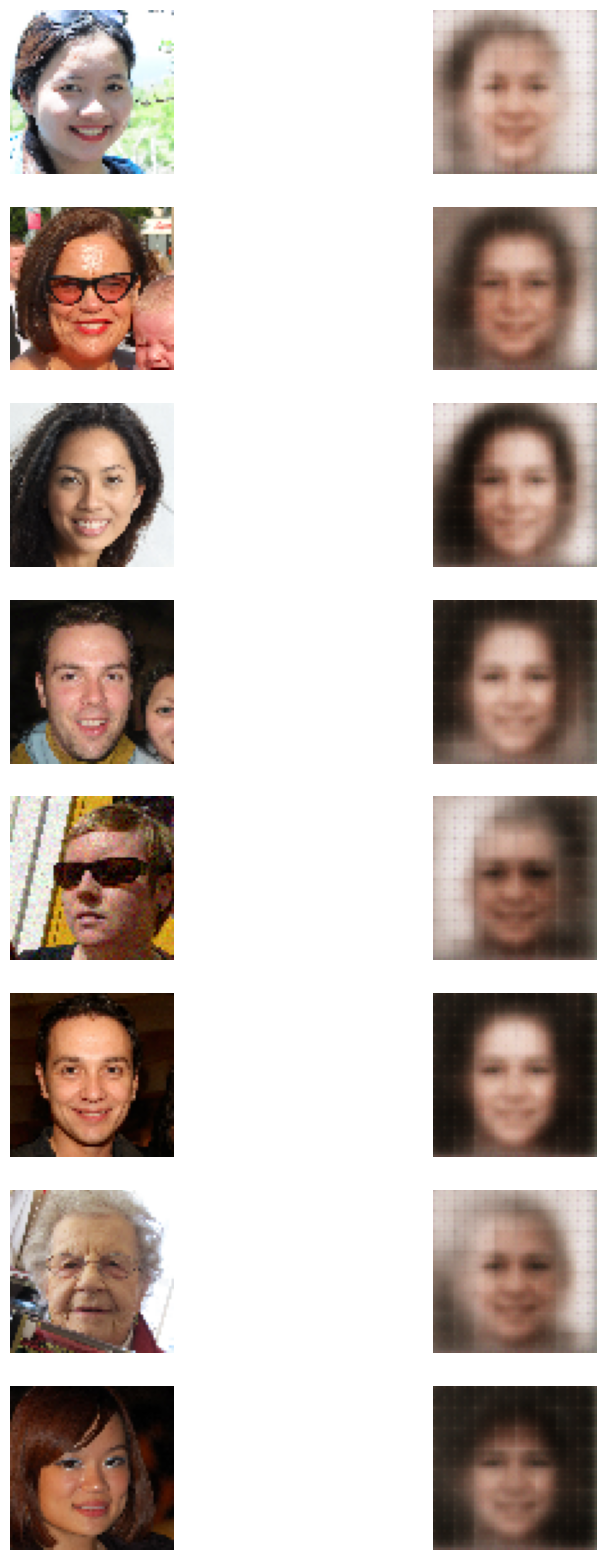

In [82]:
# Sample 8 test image reconstructions
model.eval()

with torch.no_grad():
    n = 8
    reconstructed, _ = model(x_test_tensor[:n])
    reconstructed = reconstructed.permute(0, 2, 3, 1)
    reconstructed = reconstructed.detach().cpu().numpy()
    fig, axes = plt.subplots(n, 2, figsize=(10, 20))
    for i in range(n):
        original_img = x_test_tensor[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 0].imshow(original_img)
        axes[i, 1].imshow(reconstructed[i])
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    plt.show()

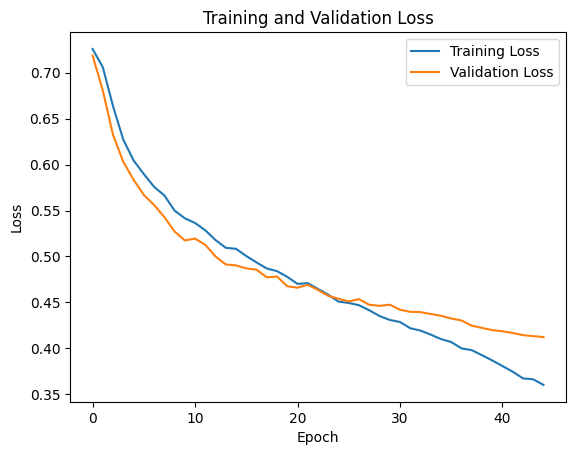

In [83]:
# Plot each loss history
plt.plot(loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

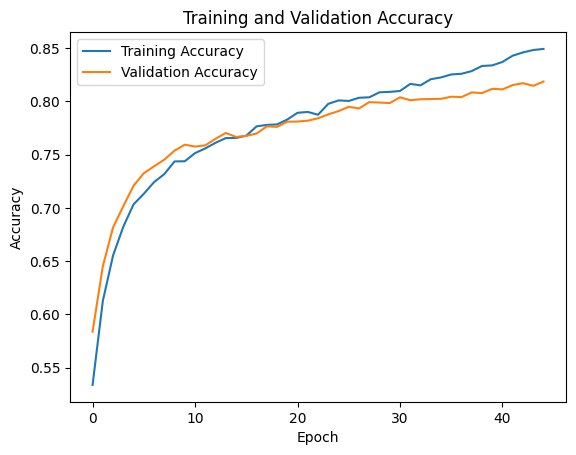

In [84]:
#acc_history = acc_history.detach().cpu().numpy()
# valid_acc_history = valid_acc_history.detach().cpu().numpy()
plt.plot(acc_history, label="Training Accuracy")
plt.plot(valid_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [85]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
temp_model = ConvAutoencoderWithClassifier(num_classes=2, latent_dim=128).to(device)
summary(temp_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
              ReLU-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
              ReLU-6             [-1, 64, 8, 8]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                  [-1, 128]         524,416
              ReLU-9                  [-1, 128]               0
           Linear-10                 [-1, 4096]         528,384
             ReLU-11                 [-1, 4096]               0
        Unflatten-12             [-1, 64, 8, 8]               0
  ConvTranspose2d-13           [-1, 32, 16, 16]          18,464
             ReLU-14           [-1, 32,